In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
import pandas as pd

### Calculate the Total Energy Stored in Resonator

In [25]:
# Parameters
y_step_um = 0.1  # µm between each layer
epsilon_floor = 1e-15  # To avoid divide-by-zero

In [26]:
# Load CSVs
folder = r'C:\Users\user\Desktop\CU Boulder Life\博二下\McRae_Lab\Ring Resonators in a Coffin-style Microwave Package\Apr_01_Cross_Section\follow_paper'

e_field_file_name = r'E.csv'
e_field_file_path = os.path.join(folder, e_field_file_name)

d_field_file_name = r'D.csv'
d_field_file_path = os.path.join(folder, d_field_file_name)

# Read data
df_E = pd.read_csv(e_field_file_path)
df_D = pd.read_csv(d_field_file_path)

In [27]:
# Extract distance and field arrays
x_um = df_E.iloc[:, 0].values  # 1st column is distance (µm)
E = df_E.iloc[:, 1:].values.T  # shape: [y, x]
D = df_D.iloc[:, 1:].values.T  # shape: [y, x]

In [28]:
# Calculate permittivity ε = D / E (avoid divide-by-zero)
with np.errstate(divide='ignore', invalid='ignore'):
    epsilon = np.where(np.abs(E) > epsilon_floor, D / E, 0)

# Calculate energy density: ε * E^2
energy_density = epsilon * E**2

# Convert microns to meters
x_m = x_um * 1e-6
y_step_m = y_step_um * 1e-6

# Integrate along x (m)
energy_x_integral = np.trapz(energy_density, x=x_m, axis=1)  # shape: [y]

# Integrate along y (m): sum * delta_y
total_energy_per_length = np.sum(energy_x_integral) * y_step_m  # J/m

print(f"Total energy per unit length ∫ε|E|² dxdy = {total_energy_per_length:.4e} J/m")

Total energy per unit length ∫ε|E|² dxdy = 8.9247e-05 J/m


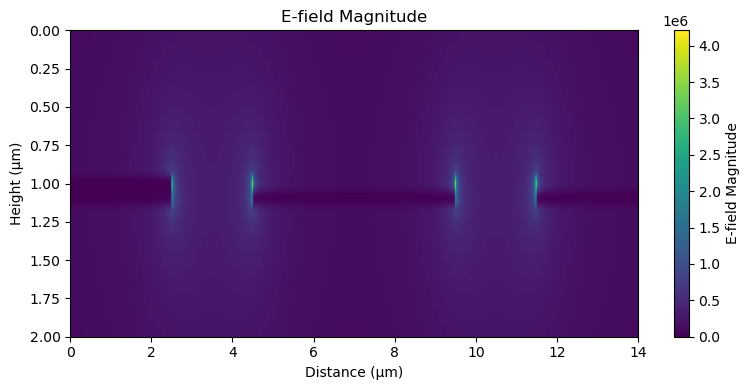

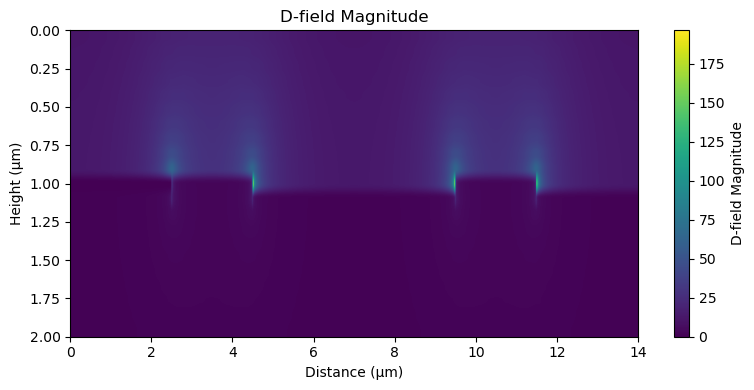

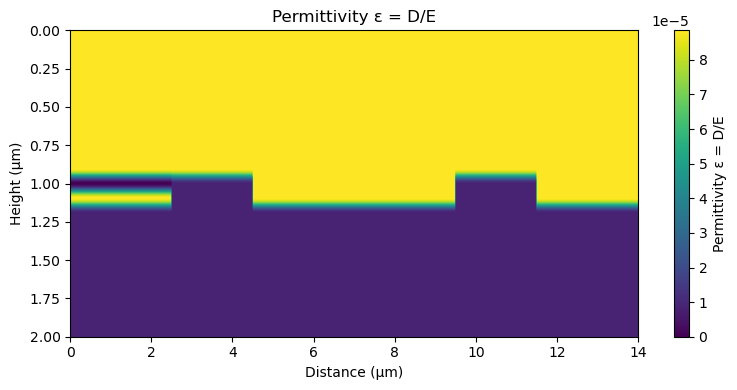

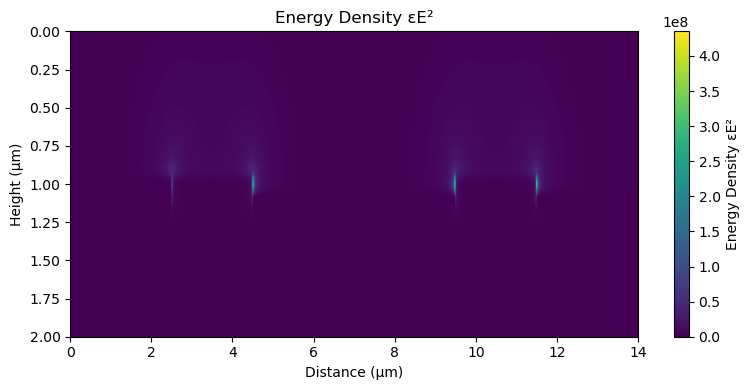

In [29]:
# Optional heatmaps
def plot_heatmap(data, title, x_um, y_um, cmap='viridis'):
    plt.figure(figsize=(8, 4))
    plt.imshow(data, extent=[x_um[0], x_um[-1], y_um[-1], y_um[0]], aspect='auto', cmap=cmap)
    plt.colorbar(label=title)
    plt.xlabel('Distance (µm)')
    plt.ylabel('Height (µm)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

y_um = np.arange(E.shape[0]) * y_step_um  # vertical axis (µm)

plot_heatmap(E, 'E-field Magnitude', x_um, y_um)
plot_heatmap(D, 'D-field Magnitude', x_um, y_um)
plot_heatmap(epsilon, 'Permittivity ε = D/E', x_um, y_um)
plot_heatmap(energy_density, 'Energy Density εE²', x_um, y_um)

### Calculate the E-field at Interface

In [15]:
# --- Set folder and file name ---
folder = r'C:\Users\user\Desktop\CU Boulder Life\博二下\McRae_Lab\Ring Resonators in a Coffin-style Microwave Package\Apr_01_Cross_Section\follow_paper\area_method'
file_name = r'E_MS_ground.csv'
file_path = os.path.join(folder, file_name)

# --- Load CSV with header ---
df = pd.read_csv(file_path, header=0)

# --- Determine unit of distance from header ---
distance_label = df.columns[0].lower()
if 'nm' in distance_label:
    unit_scale = 1e-9  # convert nm to meters
    distance_unit = 'nm'
elif 'um' in distance_label or 'μm' in distance_label:
    unit_scale = 1e-6  # convert μm to meters
    distance_unit = 'μm'
else:
    raise ValueError("Unknown distance unit: please include 'nm' or 'um' in the first column header.")

# --- Extract data ---
distance_raw = df.iloc[:, 0].values
distance_m = distance_raw * unit_scale
E_para = df.iloc[:, 1].values
E_perp = df.iloc[:, 2].values

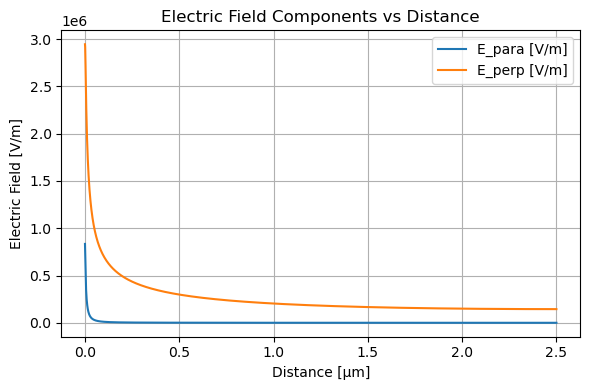

In [16]:
# --- Plot E_para and E_perp vs distance ---
plt.figure(figsize=(6, 4))
plt.plot(distance_raw, E_para, label='E_para [V/m]')
plt.plot(distance_raw, E_perp, label='E_perp [V/m]')
plt.xlabel(f'Distance [{distance_unit}]')
plt.ylabel('Electric Field [V/m]')
plt.title('Electric Field Components vs Distance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# --- Compute |E|^2 and integrate ---
E_para_sq = np.abs(E_para) ** 2
E_perp_sq = np.abs(E_perp) ** 2

int_E_para_sq = simpson(E_para_sq, x=distance_m)
int_E_perp_sq = simpson(E_perp_sq, x=distance_m)


print(f"∫|E_para|^2 dx = {int_E_para_sq:.4e} V^2·m")
print(f"∫|E_perp|^2 dx = {int_E_perp_sq:.4e} V^2·m")

∫|E_para|^2 dx = 2.6870e+03 V^2·m
∫|E_perp|^2 dx = 3.1759e+05 V^2·m


In [31]:
# Define common parameter
W = 4.46354E-11  # energy per unit length in Joules/m

if 'MA' in file_name:
    epsilon_MA = 10
    t_MA = 3e-9 # thickness in meters
    result_MA = (1 / epsilon_MA) * int_E_perp_sq * (t_MA / W)
    print(f"[MA] Participation Ratio = {int(result_MA * 1e6)} ppm")

elif 'MS' in file_name:
    epsilon_S = 10
    epsilon_MS = 10
    t_MS = 3e-9 # thickness in meters
    result_MS = (epsilon_S ** 2 / epsilon_MS) * int_E_perp_sq * (t_MS / W)
    print(f"[MS] Participation Ratio = {int(result_MS * 1e6)} ppm")

elif 'SA' in file_name:
    epsilon_SA = 10
    t_SA = 3e-9 # thickness in meters
    term_para = epsilon_SA * int_E_para_sq
    term_perp = (1 / epsilon_SA) * int_E_perp_sq
    result_SA = (term_para + term_perp) * (t_SA / W)
    print(f"[SA] Participation Ratio = {int(result_SA * 1e6)} ppm")

elif 'C' in file_name:
    epsilon_MA = 10
    t_MA = 3e-9 # thickness in meters
    result_C = (1 / epsilon_MA) * int_E_perp_sq * (t_MA / W)
    print(f"[C] Participation Ratio = {int(result_C * 1e6)} ppm")

else:
    print("No interface type detected in filename.")

[MS] Participation Ratio = 213458783358904 ppm
